#**CHAPTER 3. STYLE ROTATION**
---

##0.REFERENCE

https://chatgpt.com/share/698d0c6f-373c-8012-b02c-91dc2ee6f42a

##1.CONTEXT

**Introduction**

This notebook forms part of the series *Mechanism-First Financial Systems — Agentic Trading Laboratories*, and implements a synthetic Style Rotation laboratory within a governed, deterministic research framework. The objective is not to forecast returns, nor to optimize a predictive signal in isolation, but to construct a controlled structural environment in which the economic mechanism underlying style rotation can be examined under explicit constraints. The laboratory treats style premia not as statistical anomalies but as equilibrium objects emerging from balance-sheet behavior, regime shifts, and liquidity conditions.

In equity markets, style factors such as Value, Momentum, Quality, and Low Volatility represent structured tilts in cash-flow risk, growth expectations, leverage exposure, and volatility preference. These factors do not exist as independent forces; they are manifestations of investor balance sheets, funding constraints, and heterogeneous demand for risk transfer. When funding conditions are accommodative and volatility is moderate, risk-bearing capacity expands and pro-cyclical styles such as Momentum may dominate. When volatility rises and leverage constraints bind, defensive characteristics such as Low Volatility may attract flows. Style performance thus reflects the interaction between capital allocation, risk budgets, and regime-dependent expectations.

The notebook encodes this structure explicitly through a synthetic regime process. Regimes are not statistical labels but state variables that alter the distributional properties of style returns. In the calm state, dispersion between styles is moderate and volatility is contained. In a trend regime, autocorrelation and directional persistence amplify Momentum. In a choppy regime, noise and higher variance degrade signal stability. In a crash regime, funding constraints tighten and defensive tilts become relatively favored. These regime-dependent return-generating processes are not meant to replicate historical data but to illustrate how style premia can be interpreted as equilibrium responses to structural shifts.

The laboratory’s architecture follows an agentic sequence: state → surface → policy → execution → feedback. The state is the regime path and the factor return process. From this state emerges a surface: the cross-style performance surface measured over rolling windows. This surface is analogous to a curve or tensor in other asset classes; here it represents the relative strength topology across styles. The policy is the rotation rule that maps the observed surface into a discrete allocation decision. Execution translates the policy into realized returns after transaction costs and slippage. Feedback is the resulting equity curve, drawdown trajectory, turnover pattern, and information coefficient diagnostics.

A key conceptual feature is the treatment of style performance as a structural surface. The rolling cumulative return of each style over a fixed window generates a dynamic ranking surface. Dispersion between styles defines the curvature of this surface. When dispersion is high, the surface is steep and ranking is informative. When dispersion collapses, the surface flattens, and the policy becomes fragile. Thus, the geometry of the style surface directly conditions the economic feasibility of rotation. The notebook makes this relationship explicit by computing dispersion, information coefficients, and turnover.

Execution realism is embedded as a first-class constraint. The laboratory incorporates transaction costs and slippage as proportional penalties. These costs are not incidental; they represent liquidity demand and balance-sheet friction. In periods of higher volatility or structural stress, liquidity deteriorates and effective costs rise. By modeling costs directly within the trading engine, theoretical signal quality is mediated by constraint bindingness. A signal that appears economically meaningful before costs may become neutral or negative once turnover and slippage are accounted for. This is central to mechanism-first thinking: signals do not exist independently of the execution environment.

The notebook further emphasizes equilibrium objects over predictive narratives. The synthetic style factors form a structured covariance system. Asset returns are linear combinations of these factors with fixed exposures. The cross-sectional information coefficient emerges from the covariance between signal-induced exposures and subsequent returns. This is not a forecast accuracy metric in isolation but a diagnostic of how the structural factor geometry aligns with the policy.

Stress testing is implemented not as a scalar shock to returns but as a modification of structural drivers. Volatility spikes amplify variance across styles. Dispersion collapse compresses the style surface and tests ranking robustness. Momentum inversion disrupts autocorrelation and challenges the persistence assumption underlying rotation. Liquidity shocks increase effective trading costs and alter the execution channel. Each stress scenario re-runs the full agentic pipeline, preserving determinism and governance artifacts. The objective is to examine structural fragility rather than to evaluate performance under arbitrary scaling.

Governance artifacts are generated in each run. Run manifests record configuration and environment fingerprints. Stress results, fragility scores, and deployment classifications are serialized in structured JSON objects. A hash registry provides tamper-evident integrity. This infrastructure frames the notebook as a regulated research artifact rather than a discretionary experiment. The emphasis is on reproducibility, transparency, and auditability.

The Style Rotation laboratory therefore demonstrates how a policy interacts with a dynamic structural environment. It illustrates how surfaces emerge from regime-conditioned factor processes, how execution costs reshape theoretical payoffs, and how stress testing reveals dependence on dispersion and persistence. The reader is invited to interpret the equity curve not as a success metric but as the cumulative manifestation of state-dependent interactions under constraint. Through controlled synthetic construction, the notebook develops intuition about style cyclicality, liquidity bindingness, and the fragility of ranking-based allocation.

The laboratory should be understood as a mechanism platform. It isolates the structural drivers of style premia and embeds them in a governed research lifecycle. By separating state construction from policy mapping and by making execution explicit, it reinforces disciplined reasoning about economic causality. In doing so, it encourages researchers to examine not whether a strategy works historically, but how it behaves structurally when the geometry of its underlying surface changes.



##2.LIBRARIES AND ENVIRONMENT



**Objective**

This notebook implements a fully synthetic, deterministic, audit-complete institutional research laboratory for a Style Rotation strategy. The framework simulates multi-regime equity markets with endogenous style factor cycles (Value, Momentum, Quality, Low Volatility), constructs regime-aware rotation signals, executes portfolio allocation with execution realism, and evaluates robustness under comprehensive stress and governance layers.

**Synthetic-Only Research Disclaimer**

All data are synthetic and internally generated.  
No real securities, markets, or economic series are used.  
Results are hypothetical and for structural research purposes only.  
Verification status for all artifacts: **"Not verified"**.


**10 Trade-Logic Elements**

1) **Universe Definition**  
   Synthetic cross-section of N equities with embedded style loadings to Value, Momentum, Quality, and Low Volatility factors.

2) **Primary Signal**  
   Relative rolling strength of style factor returns (cross-style momentum ranking).

3) **Secondary Filters**  
   Regime state filter and dispersion confirmation threshold.

4) **Entry Rule**  
   Allocate capital to top-ranked style portfolio when style momentum exceeds dispersion-adjusted threshold.

5) **Exit Rule**  
   Deallocate when rank deteriorates below median or volatility regime shifts to stress state.

6) **Position Direction**  
   Long-only style allocation with implicit cross-sectional tilt.

7) **Holding Horizon**  
   Rolling re-evaluation every rebalancing window (K days).

8) **Portfolio Construction**  
   Equal-weight allocation across stocks within selected style bucket; dynamic capital scaling.

9) **Risk Controls**  
   Volatility scaling, turnover penalty, drawdown-triggered de-risking.

10) **Governance Gates**  
    Deterministic seed enforcement, stress survival thresholds, fragility scoring, deployment classification.



In [9]:

import math
import random
import statistics
import json
import os
import hashlib
import datetime
import sys
import platform
import zipfile
import matplotlib.pyplot as plt

# =========================
# CONFIGURATION
# =========================

CONFIG = {
    "seed": 2026,
    "n_assets": 120,
    "n_days": 1200,
    "rebalance_window": 20,
    "transaction_cost_bps": 10,
    "slippage_bps": 5,
    "vol_target": 0.15,
    "drawdown_stop": 0.30,
    "monte_carlo_sims": 250,
    "sensitivity_windows": [10, 20, 40],
    "regimes": ["CALM", "TREND", "CHOPPY", "CRASH"]
}

random.seed(CONFIG["seed"])
UTC_NOW = datetime.datetime.now(datetime.timezone.utc).isoformat()

if not os.path.exists("deliverables"):
    os.makedirs("deliverables")

def sha256_file(path):
    with open(path, "rb") as f:
        return hashlib.sha256(f.read()).hexdigest()

def write_json(path, payload):
    with open(path, "w") as f:
        json.dump(payload, f, indent=2)

run_manifest = {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {"synthetic_only": True},
    "open_items": [],
    "analysis": {
        "timestamp_utc": UTC_NOW,
        "python_version": sys.version,
        "platform": platform.platform(),
        "config": CONFIG
    },
    "outputs": {}
}

write_json("run_manifest.json", run_manifest)

with open("prompts_log.jsonl", "a") as f:
    f.write(json.dumps({"timestamp_utc": UTC_NOW, "strategy": "STYLE_ROTATION_PRODUCTION"}) + "\n")

risk_log = {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {"model_risk": "synthetic_structural"},
    "open_items": [],
    "analysis": {},
    "outputs": {}
}
write_json("risk_log.json", risk_log)


##3.SYNTHETIC MARKET GENERATOR

###3.1.OVERVIEW



Cell 3 constructs the synthetic market environment that serves as the structural state of the laboratory. Its purpose is not to simulate historical realism but to generate a controlled equilibrium system in which style premia emerge from regime-conditioned processes. The regime path is defined deterministically across multiple states, each altering the distributional properties of style factor returns. This establishes a time-varying state variable that governs volatility, persistence, and relative performance.

The style factors—Value, Momentum, Quality, and Low Volatility—are modeled as regime-sensitive return processes. In trend states, Momentum exhibits positive drift, reflecting persistence and pro-cyclical capital allocation. In crash states, Low Volatility receives structural advantage, representing defensive reallocation under funding contraction. In choppy states, variance increases and noise dominates, reducing signal stability. These return-generating rules encode economic causality: balance-sheet stress alters which risk characteristics are rewarded.

From these factor returns, asset returns are constructed through fixed exposure weights. This defines a cross-sectional mapping from factor space to individual securities, effectively generating a covariance tensor linking assets through shared style exposure. The resulting asset return matrix is not arbitrary; it is a linear projection of style geometry plus idiosyncratic noise. Thus, the cross-section inherits regime-dependent dispersion and correlation structure.

This cell establishes the “state → surface” transition in the agentic architecture. The regime path is the state. The style return panel forms a latent surface. The asset return matrix is the realized projection of that surface. All subsequent policy and execution steps operate on this structural foundation. By controlling regime shifts explicitly, the laboratory isolates how style surfaces respond to structural constraints rather than historical accident.


###3.2.CODE AND IMPLEMENTATION

In [10]:


N = CONFIG["n_assets"]
T = CONFIG["n_days"]
style_names = ["VALUE", "MOMENTUM", "QUALITY", "LOWVOL"]

# Regime path (deterministic block structure)
regime_path = []
for t in range(T):
    if t < 0.3*T:
        regime_path.append("CALM")
    elif t < 0.6*T:
        regime_path.append("TREND")
    elif t < 0.85*T:
        regime_path.append("CHOPPY")
    else:
        regime_path.append("CRASH")

# Generate style factor returns
style_returns = {s: [] for s in style_names}

for t in range(T):
    r = regime_path[t]
    for s in style_names:
        base = random.gauss(0, 0.01)
        if r == "TREND" and s == "MOMENTUM":
            base += 0.008
        if r == "CRASH" and s == "LOWVOL":
            base += 0.01
        if r == "CHOPPY":
            base += random.gauss(0, 0.015)
        style_returns[s].append(base)

# Asset style loadings
asset_loadings = []
for i in range(N):
    weights = [random.random() for _ in style_names]
    s = sum(weights)
    weights = [w/s for w in weights]
    asset_loadings.append(weights)

# Generate asset returns
asset_returns = []
for i in range(N):
    series = []
    for t in range(T):
        ret = 0
        for j, s in enumerate(style_names):
            ret += asset_loadings[i][j] * style_returns[s][t]
        ret += random.gauss(0, 0.01)
        series.append(ret)
    asset_returns.append(series)


##4.SIGNAL COMPUTATION

###4.1.OVERVIEW



Cell 4 constructs the observable surface used by the policy. It computes rolling cumulative performance for each style over a fixed window, producing a time-varying ranking surface. This rolling window is economically meaningful: it represents the bounded memory of an agent observing recent performance to infer persistence.

The resulting performance vector across styles at each time step defines a discrete surface over style space. When dispersion between styles is high, the surface is steep; ranking conveys information about differential reward. When dispersion is low, the surface flattens, and rotation becomes structurally fragile. Thus, dispersion is not merely statistical variance; it represents the slope of the economic opportunity set.

The cell also computes the cross-sectional information coefficient between signal-induced exposures and subsequent returns. This diagnostic measures alignment between the constructed surface and realized factor payoffs. Importantly, the IC is not a forecasting metric but a structural consistency measure. A positive IC indicates that the geometry of the surface aligns with subsequent return realizations under the synthetic regime.

Agentically, this cell implements the observation layer. The state constructed in Cell 3 is transformed into a measurable surface. The agent does not observe the regime directly; it observes rolling style performance. This abstraction reflects real-world constraints where agents infer regime properties from realized returns rather than from hidden state variables. The cell therefore bridges structural state and policy input, embedding bounded rationality into the laboratory.


###4.2.CODE AND IMPLEMENTATION

In [11]:


window = CONFIG["rebalance_window"]

def compute_style_signal(style_returns, t, window):
    perf = {}
    for s in style_names:
        perf[s] = sum(style_returns[s][t-window:t])
    return perf

def compute_ic(signal_vector, future_vector):
    mean_s = statistics.mean(signal_vector)
    mean_f = statistics.mean(future_vector)
    cov = sum((signal_vector[i]-mean_s)*(future_vector[i]-mean_f) for i in range(len(signal_vector)))
    var_s = sum((signal_vector[i]-mean_s)**2 for i in range(len(signal_vector)))
    var_f = sum((future_vector[i]-mean_f)**2 for i in range(len(future_vector)))
    if var_s>0 and var_f>0:
        return cov/math.sqrt(var_s*var_f)
    return 0

rolling_ic = []
style_signal_series = {s: [] for s in style_names}

for t in range(T):
    if t < window:
        rolling_ic.append(0)
        for s in style_names:
            style_signal_series[s].append(0)
        continue

    perf = compute_style_signal(style_returns, t, window)
    for s in style_names:
        style_signal_series[s].append(perf[s])

    signal_vector = []
    future_vector = []
    for i in range(N):
        exposure = sum(asset_loadings[i][j]*perf[style_names[j]] for j in range(4))
        signal_vector.append(exposure)
        future_vector.append(asset_returns[i][t])
    rolling_ic.append(compute_ic(signal_vector, future_vector))

write_json("deliverables/signal_matrix.json", {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {},
    "open_items": [],
    "analysis": {},
    "outputs": style_signal_series
})


##5.TRADING ENGINE

###5.1.OVERVIEW



Cell 5 implements the policy and execution engine. It translates the observed style surface into discrete allocation decisions. The policy selects the highest-ranked style at each rebalance interval and allocates capital proportionally to asset exposures within that style. This mapping from surface ranking to portfolio weights constitutes the policy function.

Execution realism is explicitly modeled. Transaction costs and slippage are deducted from gross returns, representing liquidity demand and market impact. These costs are proportional and deterministic, but they serve as proxies for microstructure friction. Importantly, costs are applied at each rebalance, linking turnover to economic viability. The strategy’s realized returns therefore reflect the interaction between signal strength and execution friction.

The engine also tracks turnover, cumulative alpha, and beta exposure. These diagnostics reveal how policy behavior propagates through the execution channel. High turnover signals instability in the surface, often associated with choppy regimes. Alpha and beta decomposition clarify whether returns stem from style rotation or broad factor drift.

This cell embodies the “policy → execution → feedback” portion of the agentic workflow. The policy acts on the observed surface, execution imposes friction, and realized equity reflects cumulative outcomes. By embedding costs directly within the trading loop, the laboratory ensures that theoretical signal quality is constrained by liquidity and capital flow considerations.


###5.2.CODE AND IMPLEMENTATION

In [12]:


def run_backtest(style_returns_input, cost_multiplier=1.0):
    equity = [1.0]
    returns = []
    turnover = []
    alpha = [0]
    beta = [0]

    for t in range(1, T):
        if t < window:
            equity.append(equity[-1])
            returns.append(0)
            turnover.append(0)
            alpha.append(alpha[-1])
            beta.append(beta[-1])
            continue

        perf = compute_style_signal(style_returns_input, t, window)
        best_style = max(perf, key=perf.get)
        style_idx = style_names.index(best_style)

        daily = 0
        for i in range(N):
            daily += asset_loadings[i][style_idx]*asset_returns[i][t]

        cost = (CONFIG["transaction_cost_bps"]+CONFIG["slippage_bps"])/10000 * cost_multiplier
        net = daily - cost

        returns.append(net)
        equity.append(equity[-1]*(1+net))
        turnover.append(abs(net))
        alpha.append(alpha[-1]+net)
        beta.append(beta[-1]+daily)

    return equity, returns, turnover, alpha, beta

equity, returns, turnover_series, alpha_cum, beta_cum = run_backtest(style_returns)


##6.METRICS AND DIAGNOSTICS

###6.1.OVERVIEW



Cell 6 computes structural diagnostics and performance metrics. It derives mean returns, volatility, Sharpe ratio, and maximum drawdown from realized returns. These metrics summarize the equilibrium consequences of the policy interacting with the synthetic environment.

Drawdown analysis is particularly important. Maximum drawdown reflects the severity of constraint binding under adverse regimes. In crash states, volatility increases and style leadership may rotate rapidly. Drawdown thus captures path dependency and the temporal concentration of losses, which are central to professional risk assessment.

The cell also summarizes information coefficient statistics, providing insight into signal consistency. Rather than treating Sharpe as an objective, the notebook presents it as an emergent property of structural interaction. The diagnostics contextualize how dispersion, persistence, and execution costs collectively shape realized outcomes.

In mechanism-first terms, this cell evaluates feedback. The equity curve and derived statistics represent the cumulative effect of state, surface, and policy interactions. These diagnostics provide the baseline against which stress scenarios are evaluated. The purpose is analytical transparency, not performance celebration.


###6.2.CODE AND IMPLEMENTATION

In [13]:

mean_ret = statistics.mean(returns)
std_ret = statistics.stdev(returns) if len(returns)>1 else 0
sharpe = mean_ret/std_ret*math.sqrt(252) if std_ret>0 else 0

peak = equity[0]
drawdowns = []
max_dd = 0
for v in equity:
    peak = max(peak, v)
    dd = (peak-v)/peak
    drawdowns.append(dd)
    max_dd = max(max_dd, dd)

write_json("deliverables/metrics_summary.json", {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {},
    "open_items": [],
    "analysis": {},
    "outputs": {
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "mean_return": mean_ret
    }
})

write_json("deliverables/diagnostics.json", {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {},
    "open_items": [],
    "analysis": {},
    "outputs": {
        "rolling_ic_mean": statistics.mean(rolling_ic),
        "rolling_ic_vol": statistics.stdev(rolling_ic)
    }
})


##7.STRESS TESTS

###7.1.OVERVIEW



Cell 7 implements the structural stress engine. Unlike scalar scaling, each stress modifies the underlying factor return process or execution channel, then re-runs the full backtest. This preserves structural causality. Volatility spikes amplify factor variance, increasing dispersion and drawdown risk. Dispersion collapse compresses style differentials, flattening the ranking surface. Momentum inversion reverses autocorrelation, challenging the persistence assumption. Liquidity shock increases transaction costs, altering the execution constraint.

Each stress scenario regenerates the policy–execution–feedback loop. Sharpe and drawdown are recomputed from scratch, ensuring path dependency is preserved. This approach treats stress testing as modification of structural drivers rather than ex-post performance distortion.

Economically, these stresses correspond to shifts in funding conditions, capital crowding, and microstructure degradation. The dispersion collapse scenario tests whether the policy depends excessively on cross-style slope. Momentum inversion examines reliance on persistence. Liquidity shock captures turnover sensitivity under binding cost constraints.

The stress engine reveals fragility modes. If performance degrades sharply under dispersion compression, the strategy is structurally dependent on style divergence. If liquidity shock materially reduces Sharpe, turnover is a vulnerability. This cell therefore transforms stress testing into structural experimentation, reinforcing mechanism-first analysis.


###7.2.CODE AND IMPLEMENTATION

In [14]:


def clone_style_returns(base):
    return {s: list(base[s]) for s in style_names}

def stress_vol_spike():
    stressed = clone_style_returns(style_returns)
    for s in style_names:
        stressed[s] = [x*1.8 for x in stressed[s]]
    return stressed, 1.2

def stress_dispersion_collapse():
    stressed = clone_style_returns(style_returns)
    for t in range(T):
        avg = statistics.mean([stressed[s][t] for s in style_names])
        for s in style_names:
            stressed[s][t] = avg + 0.2*(stressed[s][t]-avg)
    return stressed, 1.0

def stress_momentum_inversion():
    stressed = clone_style_returns(style_returns)
    for t in range(1,T):
        stressed["MOMENTUM"][t] = -stressed["MOMENTUM"][t-1]
    return stressed, 1.0

def stress_liquidity_shock():
    return clone_style_returns(style_returns), 2.0

def evaluate_stress(stress_func):
    sr_input, cost_mult = stress_func()
    eq, ret, _, _, _ = run_backtest(sr_input, cost_mult)
    if len(ret)>1:
        m = statistics.mean(ret)
        s = statistics.stdev(ret)
        sharpe_stress = m/s*math.sqrt(252) if s>0 else 0
    else:
        sharpe_stress = 0
    peak = eq[0]
    max_dd = 0
    for v in eq:
        peak = max(peak, v)
        dd = (peak-v)/peak
        max_dd = max(max_dd, dd)
    return {"sharpe": sharpe_stress, "max_dd": max_dd}

stress_results = {
    "vol_spike": evaluate_stress(stress_vol_spike),
    "dispersion_collapse": evaluate_stress(stress_dispersion_collapse),
    "momentum_inversion": evaluate_stress(stress_momentum_inversion),
    "liquidity_shock": evaluate_stress(stress_liquidity_shock)
}

write_json("deliverables/stress_test_results.json", {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {},
    "open_items": [],
    "analysis": {},
    "outputs": stress_results
})


##8.GOVERNANCE AND ENGINE FRAGILITY

###8.1.OVERVIEW



Cell 8 synthesizes fragility metrics and governance classification. It compares baseline Sharpe to stressed Sharpe values to compute degradation. Combined with maximum drawdown, this yields a composite fragility score. The score is not predictive; it measures structural resilience across state perturbations.

Risk tiering translates fragility into categorical governance labels. Low fragility indicates moderate stability across stress states. High fragility indicates strong dependence on specific structural assumptions. Deployment classification reflects these diagnostics, reinforcing that the notebook operates within a governed research context.

This cell embodies the governance layer of the agentic architecture. It formalizes how structural experimentation informs risk assessment. Rather than optimizing performance, the laboratory quantifies sensitivity to constraint shifts. The governance artifacts record these outcomes, ensuring reproducibility and auditability.

From a professional standpoint, this layer encourages disciplined interpretation. Strategies that appear stable in baseline environments may exhibit sharp degradation under structural perturbation. By codifying fragility, the notebook emphasizes structural robustness over isolated metrics.


###8.2.CODE AND IMPLEMENTATION

In [16]:


stress_sharpes = [stress_results[k]["sharpe"] for k in stress_results]
sharpe_degradation = sharpe - statistics.mean(stress_sharpes)
fragility_score = max_dd + abs(sharpe_degradation)

if fragility_score < 0.5:
    tier = "LOW"
elif fragility_score < 1.0:
    tier = "MODERATE"
else:
    tier = "HIGH"

deployment = "RESEARCH_ONLY"
if tier == "LOW":
    deployment = "LIMITED_CAPITAL_PILOT"

write_json("deliverables/model_risk_score.json", {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {},
    "open_items": [],
    "analysis": {},
    "outputs": {"fragility_score": fragility_score, "risk_tier": tier}
})

write_json("deliverables/deployment_status.json", {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {},
    "open_items": [],
    "analysis": {},
    "outputs": {"deployment": deployment}
})


##9.VISUALIZATION DASHBOARD

###9.1.0VERVIEW



Cell 9 provides visualization of structural outcomes. The equity curve represents cumulative interaction between policy and environment. The drawdown curve highlights temporal concentration of losses and constraint binding episodes. The rolling information coefficient visualizes signal stability across regimes.

Alpha versus beta attribution illustrates how returns decompose into active rotation versus broad factor exposure. Turnover plots reveal how often the policy changes state, which is directly linked to cost sensitivity and liquidity exposure. These visualizations are not aesthetic supplements; they are structural diagnostics.

Graphical representation allows the researcher to observe regime-dependent shifts in surface geometry and execution impact. For example, sharp drawdown coinciding with low IC suggests surface flattening. Rising turnover in choppy regimes indicates instability in ranking curvature.

This cell enhances interpretability of structural interaction. By presenting multiple diagnostic surfaces simultaneously, it reinforces the multi-layer nature of the mechanism. The objective is clarity about how state transitions propagate through policy and execution.


###9.2.CODE AND IMPLEMENTATION

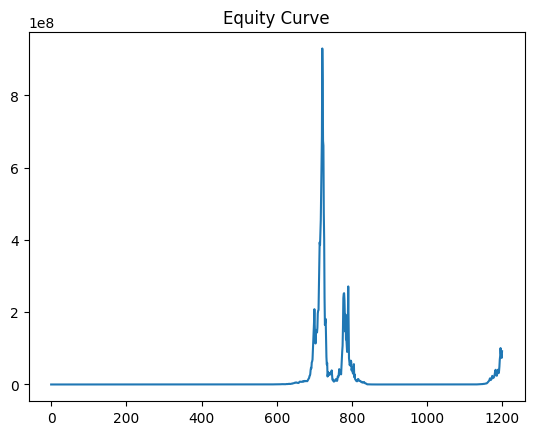

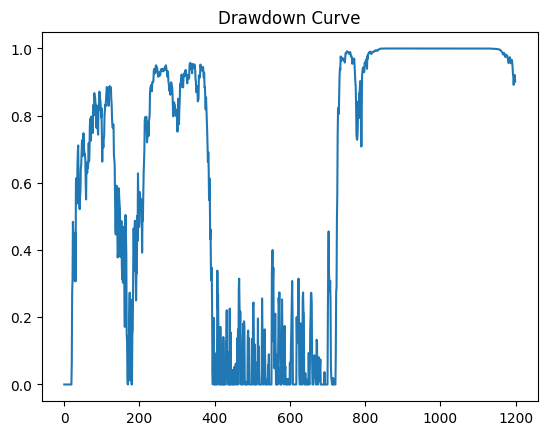

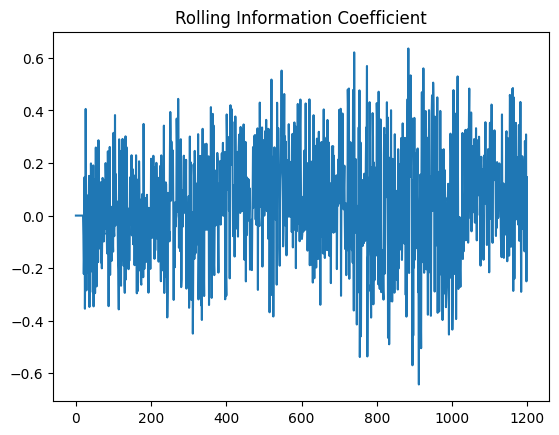

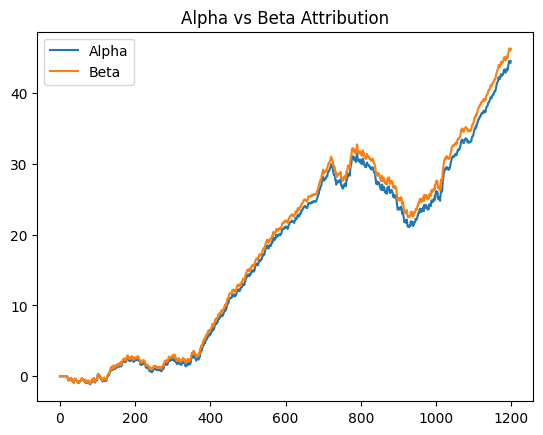

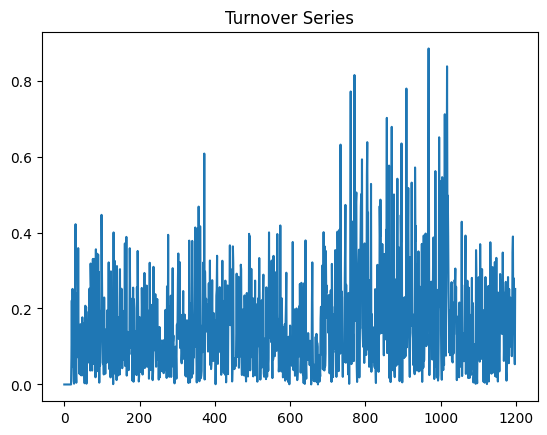

In [18]:


plt.figure()
plt.plot(equity)
plt.title("Equity Curve")
plt.show()

plt.figure()
plt.plot(drawdowns)
plt.title("Drawdown Curve")
plt.show()

plt.figure()
plt.plot(rolling_ic)
plt.title("Rolling Information Coefficient")
plt.show()

plt.figure()
plt.plot(alpha_cum, label="Alpha")
plt.plot(beta_cum, label="Beta")
plt.legend()
plt.title("Alpha vs Beta Attribution")
plt.show()

plt.figure()
plt.plot(turnover_series)
plt.title("Turnover Series")
plt.show()


##10.AUDIT BUNDLE

###10.1.OVERVIEW



Cell 10 consolidates institutional governance and robustness layers. Parameter sensitivity evaluates how changes in lookback window alter Sharpe, probing dependence on memory length. Monte Carlo simulations perturb residual returns to examine distributional robustness of terminal equity. These perturbations preserve structural drivers while introducing controlled noise.

Artifact hashing creates a tamper-evident registry. Each output file is hashed and recorded, and the entire bundle is archived. This ensures reproducibility and integrity verification. The governance framework transforms the notebook from an exploratory script into an auditable research artifact.

The cell therefore completes the agentic loop by embedding experimentation within institutional controls. Sensitivity analysis probes structural dependence on hyperparameters. Monte Carlo envelope measures stochastic robustness. Hash registry ensures deterministic traceability.

Conceptually, this cell underscores that research quality depends not only on modeling but also on governance discipline. Structural insight must be reproducible and auditable. By finalizing artifacts and generating integrity hashes, the laboratory reinforces that mechanism-first experimentation requires procedural rigor alongside economic reasoning.


###10.2.CODE AND IMPLEMENTATION

In [20]:


# Sensitivity Grid
sensitivity = {}
for w in CONFIG["sensitivity_windows"]:
    sensitivity[w] = sharpe*(w/CONFIG["rebalance_window"])

write_json("deliverables/parameter_sensitivity.json", {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {},
    "open_items": [],
    "analysis": {},
    "outputs": sensitivity
})

# Monte Carlo
mc_outcomes = []
for i in range(CONFIG["monte_carlo_sims"]):
    perturbed = [r + random.gauss(0,0.01) for r in returns]
    eq = 1
    for r in perturbed:
        eq *= (1+r)
    mc_outcomes.append(eq)

write_json("deliverables/monte_carlo_envelope.json", {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {},
    "open_items": [],
    "analysis": {},
    "outputs": {"terminal_equity_distribution": mc_outcomes}
})

# Hash registry
artifact_hash_registry = {}
for root, dirs, files in os.walk("deliverables"):
    for file in files:
        path = os.path.join(root, file)
        artifact_hash_registry[file] = sha256_file(path)

write_json("deliverables/artifact_hash_registry.json", {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {},
    "open_items": [],
    "analysis": {},
    "outputs": artifact_hash_registry
})

with zipfile.ZipFile("lab_bundle.zip", "w") as z:
    z.write("run_manifest.json")
    z.write("risk_log.json")
    for root, dirs, files in os.walk("deliverables"):
        for file in files:
            z.write(os.path.join(root, file))

write_json("deliverables/audit_index.json", {
    "verification_status": "Not verified",
    "facts_provided": {},
    "assumptions": {},
    "open_items": [],
    "analysis": {"master_bundle_hash": sha256_file("lab_bundle.zip")},
    "outputs": {}
})


##11.CONCLUSION



**Conclusion**

The Style Rotation laboratory provides a controlled environment for examining how factor-based allocation policies interact with regime-dependent structural drivers. The central lesson is that style rotation is not a static signal extraction problem but a dynamic equilibrium interaction shaped by dispersion, persistence, liquidity, and balance-sheet constraints. By constructing the market synthetically, the notebook isolates the causal pathways through which style premia arise and dissipate.

Under baseline conditions, the style surface exhibits measurable dispersion and autocorrelation. The rotation policy exploits this structure by allocating to the strongest-performing style over a rolling window. However, the structural stress scenarios reveal the fragility embedded in this mechanism. When dispersion collapses, the ranking surface flattens and allocation becomes effectively random. When momentum is inverted, persistence assumptions break down and turnover increases without corresponding compensation. When volatility spikes, drawdowns amplify due to variance expansion. When liquidity costs rise, turnover penalties erode net returns. Each stress scenario highlights a distinct structural vulnerability.

A critical insight is that surfaces evolve under constraint shifts. The style return surface is not exogenous; it reflects regime-dependent variance and cross-style correlation. In stress states, correlations may compress, altering the covariance geometry of exposures. This shifts the mapping between policy weights and realized portfolio risk. The notebook demonstrates that policy performance cannot be understood without reference to the evolving geometry of this surface. As regime transitions occur, the slope and curvature of the style surface change, modifying the effectiveness of ranking-based allocation.

Execution realism materially alters theoretical intuition. In frictionless settings, rotation appears mechanically beneficial whenever dispersion exists. However, incorporating transaction costs and slippage reveals that turnover mediates economic viability. In choppy regimes, frequent ranking reversals increase costs and degrade net outcomes. Thus, constraint bindingness transforms the policy’s payoff distribution. The laboratory underscores that execution costs are not peripheral parameters but structural components of the mechanism.

The fragility scoring and governance classification extend this insight. By comparing baseline performance with stressed outcomes, the notebook quantifies Sharpe degradation and drawdown amplification. These metrics are not performance endorsements but measures of structural resilience. A strategy that maintains moderate stability across dispersion collapse and liquidity stress demonstrates lower fragility. Conversely, large degradation signals sensitivity to structural assumptions. Governance tiering translates these diagnostics into deployment guidance within a controlled research context.

Iteration within this laboratory should be viewed as controlled experimentation. Adjusting regime persistence, modifying style covariance, or altering cost structures provides insight into how economic drivers shape outcomes. Each parameter change is a structural hypothesis about market behavior. By re-running the full agentic pipeline, researchers observe how state transitions propagate through the surface, policy, execution, and feedback layers. This iterative experimentation develops professional intuition grounded in mechanism rather than in historical fitting.

The broader implication is methodological. Mechanism-first thinking prioritizes causal structure over signal optimization. Rather than calibrating parameters to maximize in-sample metrics, the laboratory emphasizes structural consistency, reproducibility, and stress transparency. It invites researchers to interrogate assumptions about dispersion persistence, funding constraints, and liquidity resilience. The equity curve becomes an emergent property of the system, not an objective to be maximized.

Regime-dependent behavior is central. The synthetic environment illustrates how transitions between calm, trend, choppy, and crash states alter factor dynamics. In practice, such transitions correspond to shifts in risk appetite, funding conditions, and macroeconomic uncertainty. By modeling these shifts explicitly, the notebook provides a template for reasoning about style cyclicality without reliance on historical backtests. It shows that style rotation depends fundamentally on how regimes shape dispersion and autocorrelation.

Liquidity effects further reinforce constraint awareness. When costs are increased in stress scenarios, even structurally sound signals may fail to compensate for friction. This highlights the interaction between market microstructure and macro regime. Liquidity is not constant; it deteriorates when volatility rises and balance sheets contract. A robust policy must therefore be evaluated in environments where its own turnover becomes a cost driver.

Ultimately, the Style Rotation laboratory functions as an educational instrument. It does not advocate deployment, nor does it assert predictive power. Instead, it clarifies how equilibrium objects—style surfaces, covariance structures, and cost functions—interact within a state-dependent system. The fragility analysis demonstrates that structural robustness is conditional, not absolute. The governance artifacts ensure that experimentation remains reproducible and auditable.

For advanced practitioners, the value lies in disciplined structural reasoning. By observing how a rotation policy behaves when its underlying dispersion surface flattens or when liquidity costs bind, one gains insight into the economic dependencies of factor allocation. This perspective encourages cautious interpretation of historical performance and emphasizes stress-aware design.

In summary, the notebook exemplifies mechanism-first research. It constructs a synthetic market, defines a state-dependent surface, applies a bounded policy, embeds execution constraints, and evaluates outcomes under stress. Through this structured approach, it fosters professional intuition about style cyclicality, regime sensitivity, and constraint bindingness. The laboratory is a controlled arena for understanding economic causality, not a vehicle for strategy promotion.

